In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler

In [2]:
d = pd.read_excel('data_psb.xlsx')

In [91]:
data = d.copy()

In [92]:
print(data.shape)
print(list(data.columns))

(912082, 9)
['regNum', 'target', 'price', 'duration', 'revenue_post', 'days_from_first_sign_post_history', 'contracts_all_post_history', 'contracts_terminated_post_history', 'distance']


Описание признаков:
* price – стоимость контракта в рублях
* duration – длительность контракта в днях
* revenue_post – годовая выручка поставщика контракта в рублях. Если данных по выручке нет или данные недостоверные, то значение = -99
* days_from_first_sign_post_history – количество дней с момента заключения поставщиком своего первого контракта до момента заключения текущего контракта. Если в истории поставщика нет контрактов, то значение = -99
* contracts_all_post_history – количество всех заключенных контрактов в истории поставщика на момент заключения текущего контракта. Если в истории поставщика нет контрактов, то значение = -99
* contracts_terminated_post_history – количество контрактов в истории поставщика, которые были расторгнуты со стороны заказчика на момент заключения текущего контракта. Если в истории поставщика нет контрактов, то значение = -99
* distance – расстояние между регионом поставщика и регионом заказчика в километрах. Если значение = 0, то регионы заказчика и поставщика совпадают.


In [93]:
data.head()

,regNum,target,price,duration,revenue_post,days_from_first_sign_post_history,contracts_all_post_history,contracts_terminated_post_history,distance
0,X1,0,2400000.00,341,-99,745,8,0,0
1,X2,0,1228666.00,201,42165000,717,39,0,101
2,X3,0,1120009.68,364,420621000,1078,26,0,566
3,X4,0,1752594.92,109,525862000,83,4,0,566
4,X5,0,1098260.00,126,-99,853,45,0,1395


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912082 entries, 0 to 912081
Data columns (total 9 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   regNum                             912082 non-null  object 
 1   target                             912082 non-null  int64  
 2   price                              912082 non-null  float64
 3   duration                           912082 non-null  int64  
 4   revenue_post                       912082 non-null  int64  
 5   days_from_first_sign_post_history  912082 non-null  int64  
 6   contracts_all_post_history         912082 non-null  int64  
 7   contracts_terminated_post_history  912082 non-null  int64  
 8   distance                           912082 non-null  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 62.6+ MB


In [95]:
# осмотрим на пропуски
print(data.isnull().sum())

# посмотрим на наличие дубликатов
print(data.shape[0]- data.drop_duplicates().shape[0])

regNum                               0
target                               0
price                                0
duration                             0
revenue_post                         0
days_from_first_sign_post_history    0
contracts_all_post_history           0
contracts_terminated_post_history    0
distance                             0
dtype: int64
0


### Построим наивную модель модель

In [96]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['regNum', 'target'], axis=1), data['target'], test_size=0.2, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:,1]

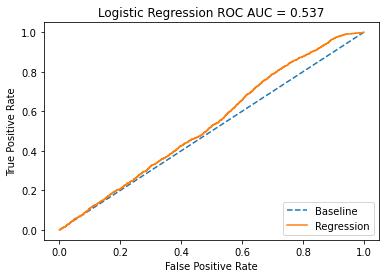

In [97]:
#рисуем ROC кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
    

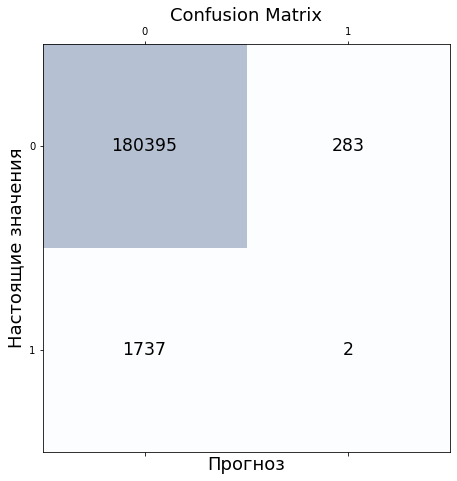

In [98]:
# рисуем confusion matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Прогноз', fontsize=18)
plt.ylabel('Настоящие значения', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

результат наивной модель = 0.537

Наивная модель едва лучше, чем случайный выбор

In [99]:
# создадим таблицу для итогового information value
ivtable=pd.DataFrame(data.columns[2:],columns=['variable'])
ivtable['IV']=None

In [100]:
# создадим таблицу для общих iv
iv_groups = pd.DataFrame()

In [101]:
def calc_iv(df, feature, target, pr=False):
    '''функция для получения information value'''
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])
    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    
    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()
    print('This variable\'s IV is:',iv)
    return iv, data

#### target

C:\Users\Tanya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


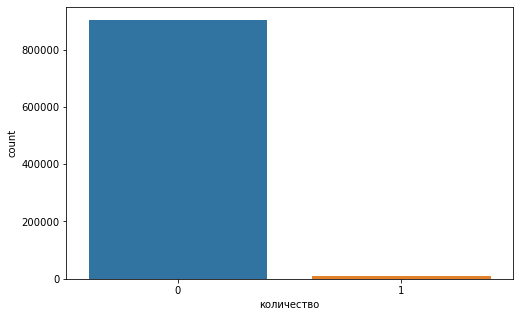

In [102]:
# взглянем на распределение целевого показателя
plt.figure(figsize=(8, 5))
sns.countplot(data['target'])
plt.xlabel('значение целевого показателя')
plt.xlabel('количество')
plt.show()

In [103]:
data['target'].value_counts()

0    903491
1      8591
Name: target, dtype: int64

выборка сильно не сбалансирована

#### price

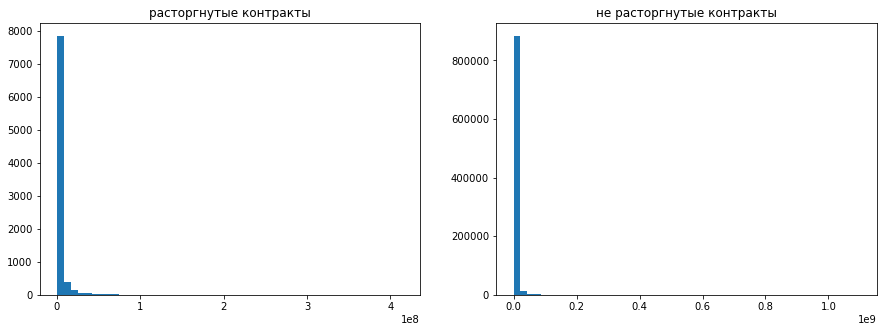

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].price, bins=50)
axes[1].hist(data[data['target'] == 0].price, bins=50)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [105]:
print(data[data['target'] == 1].price.describe())
print(data[data['target'] == 0].price.describe())
# добавим медиану
print(data[data['target'] == 1].price.median())
print(data[data['target'] == 0].price.median())

count    8.591000e+03
mean     3.738096e+06
std      1.113050e+07
min      0.000000e+00
25%      4.425110e+05
50%      1.277082e+06
75%      2.874564e+06
max      4.150555e+08
Name: price, dtype: float64
count    9.034910e+05
mean     3.322831e+06
std      1.020318e+07
min      0.000000e+00
25%      3.873504e+05
50%      1.257228e+06
75%      2.761504e+06
max      1.098166e+09
Name: price, dtype: float64
1277082.5
1257228.0


In [106]:
def price_cats(val):
    """для категоризации признака 'price'"""
    if val<= 150000:
        return 'price <= 150000'
    elif (val > 150000) and (val <= 500000):
        return '150000 < price <= 500000'
    elif (val > 500000) and (val <= 1000000):
        return '500000 < price <= 1000000'
    elif (val > 1000000) and (val <= 1500000):
        return '1000000 < price <=1500000'
    elif (val > 1500000) and (val <= 2500000):
        return '1500000 < price <=2500000'
    elif (val > 2500000) and (val <= 5000000):
        return '2500000 < price <=5000000'
    elif (val > 5000000) and (val <= 10000000):
        return '5000000 < price <= 10000000'
    else:
        return 'price > 10000000'
    
# применяем её
data['gp_price'] = data.price.apply(price_cats)

In [107]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_price', 'target')
ivtable.loc[ivtable['variable']=='Gender','IV']=iv

This variable's IV is: 0.019904196001162004


In [108]:
# добавляем его в общую таблицу
ivtable.loc[ivtable['variable']=='price','IV']=iv

In [109]:
# iv в группах
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_price,1000000 < price <=1500000,136129,134811,1318,0.149251,0.009682,0.149211,0.153416,-0.027793,0.000117
1,gp_price,150000 < price <= 500000,147071,145504,1567,0.161248,0.010655,0.161046,0.182400,-0.124510,0.002659
2,gp_price,1500000 < price <=2500000,143683,142384,1299,0.157533,0.009041,0.157593,0.151205,0.041382,0.000264
3,gp_price,2500000 < price <=5000000,132138,130955,1183,0.144875,0.008953,0.144943,0.137702,0.051249,0.000371
4,gp_price,500000 < price <= 1000000,109252,108122,1130,0.119783,0.010343,0.119671,0.131533,-0.094508,0.001121
5,gp_price,5000000 < price <= 10000000,67346,66654,692,0.073838,0.010275,0.073774,0.080549,-0.087867,0.000595
6,gp_price,price <= 150000,122466,121647,819,0.134271,0.006688,0.134641,0.095332,0.345244,0.013571
7,gp_price,price > 10000000,53997,53414,583,0.059202,0.010797,0.059120,0.067862,-0.137910,0.001206


In [110]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[6]]
for i in (1, 4, 0, 2, 3, 5, 7):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [111]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
6,gp_price,price <= 150000,122466,121647,819,0.134271,0.006688,0.134641,0.095332,0.345244,0.013571
1,gp_price,150000 < price <= 500000,147071,145504,1567,0.161248,0.010655,0.161046,0.182400,-0.124510,0.002659
4,gp_price,500000 < price <= 1000000,109252,108122,1130,0.119783,0.010343,0.119671,0.131533,-0.094508,0.001121
0,gp_price,1000000 < price <=1500000,136129,134811,1318,0.149251,0.009682,0.149211,0.153416,-0.027793,0.000117
2,gp_price,1500000 < price <=2500000,143683,142384,1299,0.157533,0.009041,0.157593,0.151205,0.041382,0.000264
3,gp_price,2500000 < price <=5000000,132138,130955,1183,0.144875,0.008953,0.144943,0.137702,0.051249,0.000371
5,gp_price,5000000 < price <= 10000000,67346,66654,692,0.073838,0.010275,0.073774,0.080549,-0.087867,0.000595
7,gp_price,price > 10000000,53997,53414,583,0.059202,0.010797,0.059120,0.067862,-0.137910,0.001206


In [112]:
# добавим в общую таблицу
iv_groups = sorted_new_df

#### duration

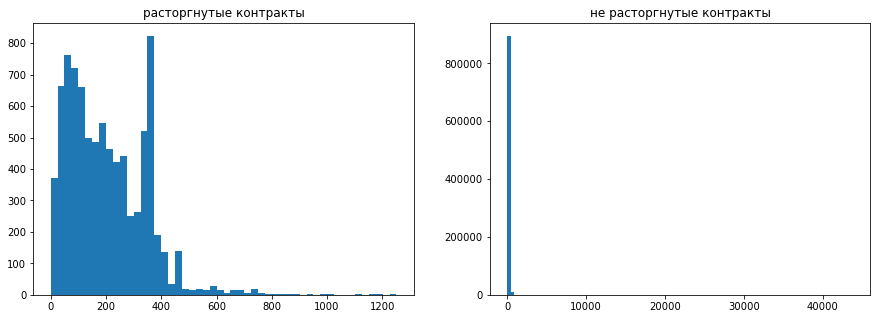

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].duration, bins=50)
axes[1].hist(data[data['target'] == 0].duration, bins=100)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [114]:
print(data[data['target'] == 1].duration.describe())
print(data[data['target'] == 0].duration.describe())
# медиана
print(data[data['target'] == 1].duration.median())
print(data[data['target'] == 0].duration.median())

count    8591.000000
mean      203.028635
std       138.610454
min         0.000000
25%        89.000000
50%       181.000000
75%       315.000000
max      1251.000000
Name: duration, dtype: float64
count    903491.000000
mean        188.237235
std         127.850211
min           0.000000
25%          87.000000
50%         178.000000
75%         279.000000
max       43828.000000
Name: duration, dtype: float64
181.0
178.0


In [115]:
def duration_cats(val):
    """для категоризации признака 'duration'"""
    if val<=61:
        return '<= 2 месяца'
    elif val > 61 and val <=122:
        return '2 месяца <  <= 4 месяца'
    elif val > 122 and val <= 183:
        return '4 месяца <  <= 6 месяцев'
    elif val > 183 and val <= 365:
        return '6 месяцев <  <=год'
    elif val > 365:
        return 'более года'
    else:
        return val

In [116]:
data['gp_duration'] = data.duration.apply(duration_cats)

In [117]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_duration', 'target')
ivtable.loc[ivtable['variable']=='duration','IV']=iv

This variable's IV is: 0.023537429274297465


In [118]:
# iv в группах
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_duration,2 месяца < <= 4 месяца,167524,165835,1689,0.183672,0.010082,0.183549,0.196601,-0.068694,0.000897
1,gp_duration,4 месяца < <= 6 месяцев,155786,154481,1305,0.170803,0.008377,0.170982,0.151903,0.118317,0.002257
2,gp_duration,6 месяцев < <=год,379894,376472,3422,0.416513,0.009008,0.416686,0.398324,0.045067,0.000828
3,gp_duration,<= 2 месяца,159329,157930,1399,0.174687,0.008781,0.174800,0.162845,0.070843,0.000847
4,gp_duration,более года,49549,48773,776,0.054325,0.015661,0.053983,0.090327,-0.514771,0.018709


In [119]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[3]]
for i in (0, 1, 2, 4):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [120]:
display(sorted_new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
3,gp_duration,<= 2 месяца,159329,157930,1399,0.174687,0.008781,0.174800,0.162845,0.070843,0.000847
0,gp_duration,2 месяца < <= 4 месяца,167524,165835,1689,0.183672,0.010082,0.183549,0.196601,-0.068694,0.000897
1,gp_duration,4 месяца < <= 6 месяцев,155786,154481,1305,0.170803,0.008377,0.170982,0.151903,0.118317,0.002257
2,gp_duration,6 месяцев < <=год,379894,376472,3422,0.416513,0.009008,0.416686,0.398324,0.045067,0.000828
4,gp_duration,более года,49549,48773,776,0.054325,0.015661,0.053983,0.090327,-0.514771,0.018709


In [121]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

#### revenue_post

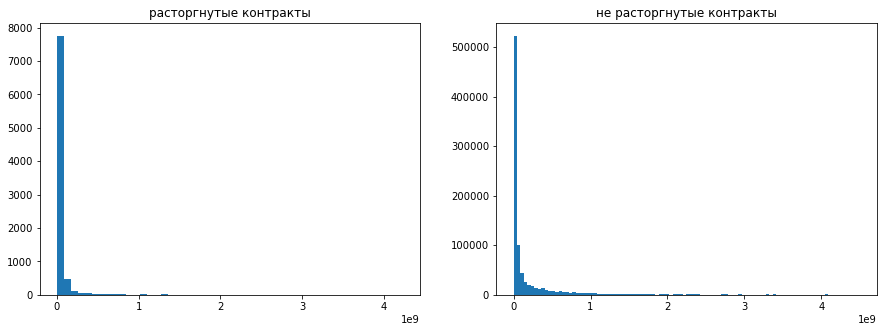

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].revenue_post, bins=50)
axes[1].hist(data[data['target'] == 0].revenue_post, bins=100)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [123]:
print(data[data['target'] == 1].revenue_post.describe())
print(data[data['target'] == 0].revenue_post.describe())
# дополнительно вдглянем на медиану
print(data[data['target'] == 1].revenue_post.median())
print(data[data['target'] == 0].revenue_post.median())

count    8.591000e+03
mean     3.859215e+07
std      1.649821e+08
min     -9.900000e+01
25%     -9.900000e+01
50%      6.800000e+04
75%      1.787800e+07
max      4.231058e+09
Name: revenue_post, dtype: float64
count    9.034910e+05
mean     2.282940e+08
std      5.421020e+08
min     -1.640000e+05
25%     -9.900000e+01
50%      2.613400e+07
75%      1.519430e+08
max      4.493357e+09
Name: revenue_post, dtype: float64
68000.0
26134000.0


у распределений сильный хвост. Выручка компаний, у которых отменяются заказы, в среднем, выручка меньше почти в 6 раз. А медианное - почти в 400

In [124]:
def revenue_post_cat(val):
    """для категоризации признака 'revenue_post'"""
    if val == (-99):
        return 'нет информации'
    elif (val >= 0) and (val <= 10000000):
        return 'revenue <= 10000000'
    elif (val > 10000000) and (val <= 40000000):
        return '10000000  < revenue <= 40000000'
    elif (val > 40000000) and (val <= 100000000):
        return '40000000 < revenue <= 100000000'
    elif (val > 100000000) and (val <= 500000000):
        return '100000000 < revenue <= 500000000'
    else:
        return 'revenue > 500000000'

In [125]:
data['gp_revenue_post'] = data.revenue_post.apply(revenue_post_cat)

In [126]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_revenue_post', 'target')

#добавляем его в общую таблицу
ivtable.loc[ivtable['variable']=='revenue_post','IV']=iv

This variable's IV is: 0.5173206214561235


In [127]:
# iv в группах
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_revenue_post,10000000 < revenue <= 40000000,139875,138641,1234,0.153358,0.008822,0.153450,0.143639,0.066076,0.000648
1,gp_revenue_post,100000000 < revenue <= 500000000,154441,153835,606,0.169328,0.003924,0.170267,0.070539,0.881205,0.087881
2,gp_revenue_post,40000000 < revenue <= 100000000,131067,130440,627,0.143701,0.004784,0.144373,0.072983,0.682171,0.048700
3,gp_revenue_post,revenue <= 10000000,99074,97314,1760,0.108624,0.017764,0.107709,0.204866,-0.642922,0.062464
4,gp_revenue_post,revenue > 500000000,114441,114296,145,0.125472,0.001267,0.126505,0.016878,2.014262,0.220817
5,gp_revenue_post,нет информации,273184,268965,4219,0.299517,0.015444,0.297695,0.491095,-0.500568,0.096810


In [128]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[5]]
for i in (3, 0, 2, 1, 4):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [129]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
5,gp_revenue_post,нет информации,273184,268965,4219,0.299517,0.015444,0.297695,0.491095,-0.500568,0.096810
3,gp_revenue_post,revenue <= 10000000,99074,97314,1760,0.108624,0.017764,0.107709,0.204866,-0.642922,0.062464
0,gp_revenue_post,10000000 < revenue <= 40000000,139875,138641,1234,0.153358,0.008822,0.153450,0.143639,0.066076,0.000648
2,gp_revenue_post,40000000 < revenue <= 100000000,131067,130440,627,0.143701,0.004784,0.144373,0.072983,0.682171,0.048700
1,gp_revenue_post,100000000 < revenue <= 500000000,154441,153835,606,0.169328,0.003924,0.170267,0.070539,0.881205,0.087881
4,gp_revenue_post,revenue > 500000000,114441,114296,145,0.125472,0.001267,0.126505,0.016878,2.014262,0.220817


In [130]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

#### days_from_first_sign_post_history

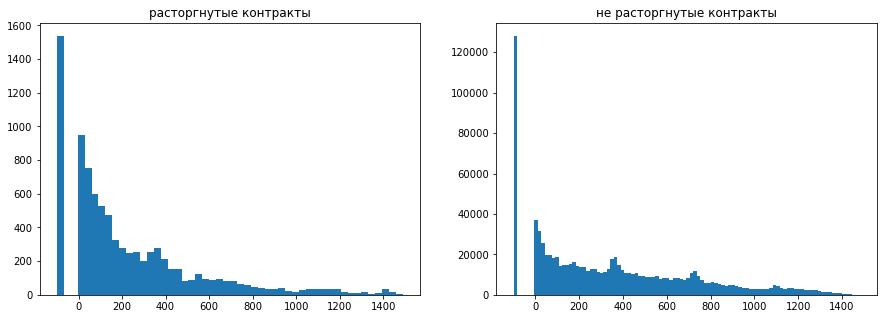

In [131]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].days_from_first_sign_post_history, bins=50)
axes[1].hist(data[data['target'] == 0].days_from_first_sign_post_history, bins=100)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [132]:
# взглянем, нет ли лишних отрицательных значений
data.days_from_first_sign_post_history.value_counts().sort_index()[:5]

-99    129627
 1       6586
 2       3933
 3       3865
 4       3134
Name: days_from_first_sign_post_history, dtype: int64

In [133]:
print(data[data['target'] == 1].days_from_first_sign_post_history.describe())
print(data[data['target'] == 0].days_from_first_sign_post_history.describe())
# дополнительно вдглянем на медиану
print(data[data['target'] == 1].days_from_first_sign_post_history.median())
print(data[data['target'] == 0].days_from_first_sign_post_history.median())

count    8591.000000
mean      217.839134
std       311.726201
min       -99.000000
25%        16.000000
50%       119.000000
75%       350.000000
max      1490.000000
Name: days_from_first_sign_post_history, dtype: float64
count    903491.000000
mean        353.281126
std         370.294824
min         -99.000000
25%          47.000000
50%         279.000000
75%         602.000000
max        1479.000000
Name: days_from_first_sign_post_history, dtype: float64
119.0
279.0


In [134]:
def days_from_first_sign_post_history_cats(val):
    """для категоризации признака 'days_from_first_sign_post_history'"""
    if val == -99:
        return 'нет информации'
    elif val<=91 and val >= 0:
        return '<= 3 месяца'
    elif val > 91 and val <=183:
        return '3 месяца <  <= 6 месяцев'
    elif val > 183 and val <= 365:
        return '6 месяцев <  <= год '
    elif val > 365 and val <= 720:
        return 'год <  <= 2 года'
    else:
        return 'более 2 лет'

In [135]:
data['gp_days_from_first_sign_post_history'] = data.days_from_first_sign_post_history.apply(days_from_first_sign_post_history_cats)

In [136]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_days_from_first_sign_post_history', 'target')

# добавляем его в общую таблицу
ivtable.loc[ivtable['variable']=='days_from_first_sign_post_history','IV']=iv

This variable's IV is: 0.19803400696671303


In [137]:
# iv в группах
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_days_from_first_sign_post_history,3 месяца < <= 6 месяцев,91508,90212,1296,0.100329,0.014163,0.099848,0.150856,-0.412671,0.021049
1,gp_days_from_first_sign_post_history,6 месяцев < <= год,154999,153525,1474,0.169940,0.009510,0.169924,0.171575,-0.009667,0.000016
2,gp_days_from_first_sign_post_history,<= 3 месяца,155413,153111,2302,0.170394,0.014812,0.169466,0.267955,-0.458166,0.045124
3,gp_days_from_first_sign_post_history,более 2 лет,164146,163466,680,0.179968,0.004143,0.180927,0.079153,0.826716,0.084139
4,gp_days_from_first_sign_post_history,год < <= 2 года,216389,215087,1302,0.237247,0.006017,0.238062,0.151554,0.451590,0.039066
5,gp_days_from_first_sign_post_history,нет информации,129627,128090,1537,0.142122,0.011857,0.141772,0.178908,-0.232650,0.008640


In [138]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[5]]
for i in (2, 0, 1, 4, 3):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [139]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
5,gp_days_from_first_sign_post_history,нет информации,129627,128090,1537,0.142122,0.011857,0.141772,0.178908,-0.232650,0.008640
2,gp_days_from_first_sign_post_history,<= 3 месяца,155413,153111,2302,0.170394,0.014812,0.169466,0.267955,-0.458166,0.045124
0,gp_days_from_first_sign_post_history,3 месяца < <= 6 месяцев,91508,90212,1296,0.100329,0.014163,0.099848,0.150856,-0.412671,0.021049
1,gp_days_from_first_sign_post_history,6 месяцев < <= год,154999,153525,1474,0.169940,0.009510,0.169924,0.171575,-0.009667,0.000016
4,gp_days_from_first_sign_post_history,год < <= 2 года,216389,215087,1302,0.237247,0.006017,0.238062,0.151554,0.451590,0.039066
3,gp_days_from_first_sign_post_history,более 2 лет,164146,163466,680,0.179968,0.004143,0.180927,0.079153,0.826716,0.084139


In [140]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

#### contracts_all_post_history

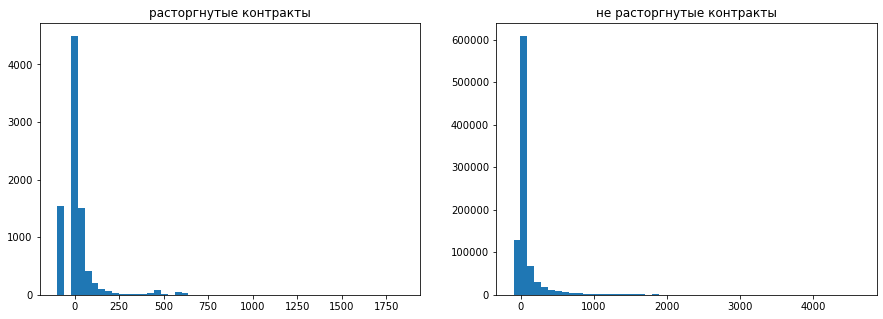

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].contracts_all_post_history, bins=50)
axes[1].hist(data[data['target'] == 0].contracts_all_post_history, bins=50)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [142]:
# посмотрим, нет ли лишних отрицательных значений
data.contracts_all_post_history.value_counts().sort_index()[:5]

-99    129627
 1      65619
 2      48053
 3      38112
 4      31824
Name: contracts_all_post_history, dtype: int64

In [143]:
print(data[data['target'] == 1].contracts_all_post_history.describe())
print(data[data['target'] == 0].contracts_all_post_history.describe())
# дополнительно вдглянем на медиану
print(data[data['target'] == 1].contracts_all_post_history.median())
print(data[data['target'] == 0].contracts_all_post_history.median())

count    8591.000000
mean       15.726109
std       103.378352
min       -99.000000
25%         1.000000
50%         6.000000
75%        22.000000
max      1843.000000
Name: contracts_all_post_history, dtype: float64
count    903491.000000
mean         79.284983
std         304.519916
min         -99.000000
25%           2.000000
50%          12.000000
75%          54.000000
max        4631.000000
Name: contracts_all_post_history, dtype: float64
6.0
12.0


In [144]:
def contracts_all_post_history_cats(val):
    """для категоризации признака 'contracts_all_post_history'"""
    if val == -99:
        return 'нет информации'
    elif val <=3 and val > 0:
        return 'менее 3х дней'
    elif val >3 and val <=14:
        return '3 дня <  <= 2 недели'
    elif val > 14 and val <=30:
        return '2 недели <  <= 1 месяц'
    elif val > 30 and val <= 61:
        return '1 месяц <  <= 2 месяца'
    elif val > 61 and val <= 182:
        return '2 месяца <  <= пол года'
    else:
        return 'более полу года'

In [145]:
data['gp_contracts_all_post_history'] = data.contracts_all_post_history.apply(contracts_all_post_history_cats)

In [146]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_contracts_all_post_history', 'target')
ivtable.loc[ivtable['variable']=='contracts_all_post_history','IV']=iv


This variable's IV is: 0.1286962642211432


In [147]:
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_contracts_all_post_history,1 месяц < <= 2 месяца,96048,95346,702,0.105306,0.007309,0.105531,0.081713,0.255783,0.006092
1,gp_contracts_all_post_history,2 месяца < <= пол года,111439,110804,635,0.122181,0.005698,0.122640,0.073915,0.506342,0.024672
2,gp_contracts_all_post_history,2 недели < <= 1 месяц,115327,114119,1208,0.126444,0.010475,0.126309,0.140612,-0.107275,0.001534
3,gp_contracts_all_post_history,3 дня < <= 2 недели,207864,205486,2378,0.227901,0.011440,0.227436,0.276801,-0.196433,0.009697
4,gp_contracts_all_post_history,более полу года,99993,99642,351,0.109632,0.003510,0.110286,0.040857,0.993002,0.068943
5,gp_contracts_all_post_history,менее 3х дней,151784,150004,1780,0.166415,0.011727,0.166027,0.207194,-0.221502,0.009118
6,gp_contracts_all_post_history,нет информации,129627,128090,1537,0.142122,0.011857,0.141772,0.178908,-0.232650,0.008640


In [148]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[6]]
for i in (5, 3, 2, 0, 1, 4):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [149]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
6,gp_contracts_all_post_history,нет информации,129627,128090,1537,0.142122,0.011857,0.141772,0.178908,-0.232650,0.008640
5,gp_contracts_all_post_history,менее 3х дней,151784,150004,1780,0.166415,0.011727,0.166027,0.207194,-0.221502,0.009118
3,gp_contracts_all_post_history,3 дня < <= 2 недели,207864,205486,2378,0.227901,0.011440,0.227436,0.276801,-0.196433,0.009697
2,gp_contracts_all_post_history,2 недели < <= 1 месяц,115327,114119,1208,0.126444,0.010475,0.126309,0.140612,-0.107275,0.001534
0,gp_contracts_all_post_history,1 месяц < <= 2 месяца,96048,95346,702,0.105306,0.007309,0.105531,0.081713,0.255783,0.006092
1,gp_contracts_all_post_history,2 месяца < <= пол года,111439,110804,635,0.122181,0.005698,0.122640,0.073915,0.506342,0.024672
4,gp_contracts_all_post_history,более полу года,99993,99642,351,0.109632,0.003510,0.110286,0.040857,0.993002,0.068943


In [150]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

#### contracts_terminated_post_history

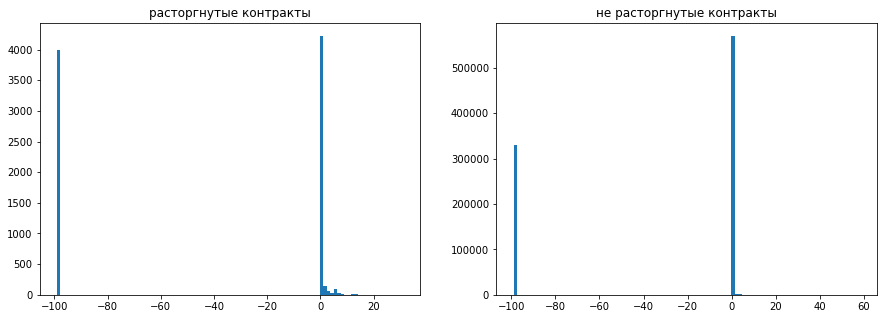

In [151]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].contracts_terminated_post_history, bins=100)
axes[1].hist(data[data['target'] == 0].contracts_terminated_post_history, bins=100)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [152]:
# взглянем, нет ли лишних отрицательных значений
print(data[data['target'] == 1].contracts_terminated_post_history.value_counts().sort_index()[:5])
print(data[data['target'] == 0].contracts_terminated_post_history.value_counts().sort_index()[:5])

-99    3988
 0     3641
 1      581
 2      140
 3       54
Name: contracts_terminated_post_history, dtype: int64
-99    329554
 0     555889
 1      14379
 2       1578
 3        623
Name: contracts_terminated_post_history, dtype: int64


In [153]:
def contracts_terminated_post_history_cats(val):
    """для категоризации признака 'contracts_terminated_post_history'"""
    if val == -99:
        return 'нет информации'
    elif val == 0:
        return 'это первый контракт'
    else:
        return 'контракты были'

In [154]:
data['gp_contracts_terminated_post_history'] = data['contracts_terminated_post_history'].apply(contracts_terminated_post_history_cats) 

In [155]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_contracts_terminated_post_history', 'target')
ivtable.loc[ivtable['variable']=='contracts_terminated_post_history','IV']=iv

This variable's IV is: 0.2539336093743283


In [156]:
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_contracts_terminated_post_history,контракты были,19010,18048,962,0.020842,0.050605,0.019976,0.111978,-1.723775,0.158590
1,gp_contracts_terminated_post_history,нет информации,333542,329554,3988,0.365693,0.011957,0.364756,0.464207,-0.241101,0.023978
2,gp_contracts_terminated_post_history,это первый контракт,559530,555889,3641,0.613465,0.006507,0.615268,0.423816,0.372759,0.071366


In [157]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[1]]
for i in (2, 0):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [158]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
1,gp_contracts_terminated_post_history,нет информации,333542,329554,3988,0.365693,0.011957,0.364756,0.464207,-0.241101,0.023978
2,gp_contracts_terminated_post_history,это первый контракт,559530,555889,3641,0.613465,0.006507,0.615268,0.423816,0.372759,0.071366
0,gp_contracts_terminated_post_history,контракты были,19010,18048,962,0.020842,0.050605,0.019976,0.111978,-1.723775,0.158590


In [159]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

#### distance

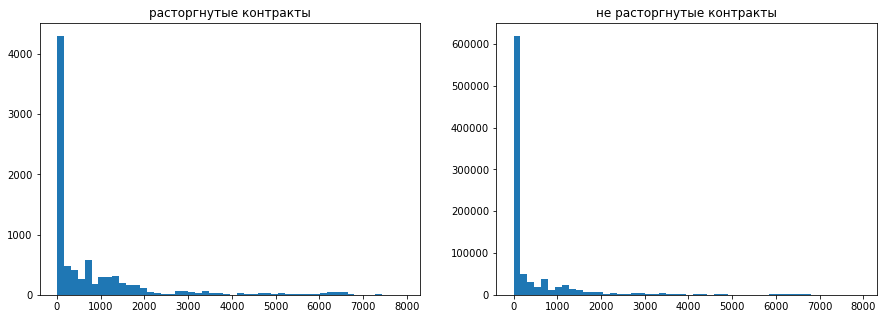

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].hist(data[data['target'] == 1].distance, bins=50)
axes[1].hist(data[data['target'] == 0].distance, bins=50)
axes[0].set_title('расторгнутые контракты')
axes[1].set_title('не расторгнутые контракты')
plt.show()

In [161]:
print(data[data['target'] == 1].distance.describe())
print(data[data['target'] == 0].distance.describe())
# дополнительно вдглянем на медиану
print(data[data['target'] == 1].distance.median())
print(data[data['target'] == 0].distance.median())

count    8591.000000
mean      780.234082
std      1352.594012
min         0.000000
25%         0.000000
50%       144.000000
75%      1053.000000
max      7913.000000
Name: distance, dtype: float64
count    903491.000000
mean        421.754017
std         997.599139
min           0.000000
25%           0.000000
50%           0.000000
75%         369.000000
max        7913.000000
Name: distance, dtype: float64
144.0
0.0


In [162]:
def distance_cats(val):
    """для категоризации признака 'distance'"""
    if val == 0:
        return 'в том же городе'
    elif val > 0 and val <= 500:
        return '0 <  <= 500'
    elif val > 500 and val <= 1000:
        return '500 <  <= 1000'
    else:
        return '>1000'

In [163]:
data['gp_distance'] = data.distance.apply(distance_cats)

In [164]:
# получаем iv
iv, new_df = calc_iv(data, 'gp_distance', 'target')
ivtable.loc[ivtable['variable']=='distance','IV']=iv

This variable's IV is: 0.15440266868809016


In [165]:
display(new_df)

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_distance,0 < <= 500,92879,91852,1027,0.101832,0.011057,0.101663,0.119544,-0.162014,0.002897
1,gp_distance,500 < <= 1000,75230,74099,1131,0.082482,0.015034,0.082014,0.131649,-0.473251,0.023490
2,gp_distance,>1000,130264,128048,2216,0.142820,0.017012,0.141726,0.257944,-0.598850,0.069597
3,gp_distance,в том же городе,613709,609492,4217,0.672866,0.006871,0.674597,0.490863,0.317951,0.058418


In [166]:
# сортируем по группам в признаке
sorted_new_df = new_df.iloc[[3]]
for i in (0, 1, 2):
    sorted_new_df = pd.concat([sorted_new_df, new_df.iloc[[i]]])

In [167]:
sorted_new_df

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
3,gp_distance,в том же городе,613709,609492,4217,0.672866,0.006871,0.674597,0.490863,0.317951,0.058418
0,gp_distance,0 < <= 500,92879,91852,1027,0.101832,0.011057,0.101663,0.119544,-0.162014,0.002897
1,gp_distance,500 < <= 1000,75230,74099,1131,0.082482,0.015034,0.082014,0.131649,-0.473251,0.023490
2,gp_distance,>1000,130264,128048,2216,0.142820,0.017012,0.141726,0.257944,-0.598850,0.069597


In [168]:
# добавим в общую таблицу
iv_groups = pd.concat([iv_groups, sorted_new_df], ignore_index=True)

In [169]:
# создадим таблицу с категорийными признаками
cats_df = data[data.columns[9:]]

# извлечём дамми переменные 
cats_df = pd.get_dummies(cats_df)

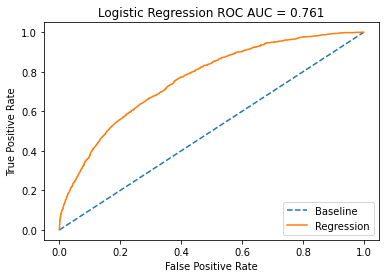

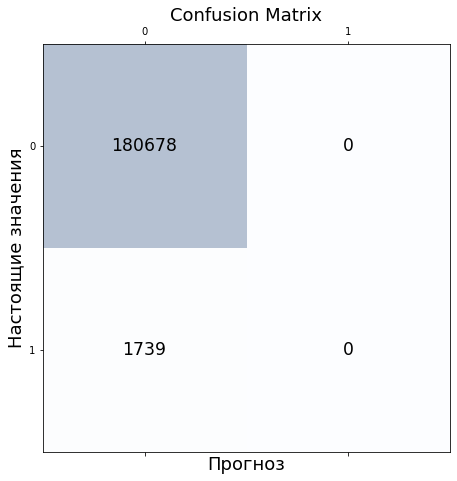

In [170]:
# cнова построим модель у обновлёнными данными
X_train, X_test, y_train, y_test = train_test_split(
    cats_df, data['target'], test_size=0.2, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:,1]

#рисуем ROC кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# рисуем confusion matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Прогноз', fontsize=18)
plt.ylabel('Настоящие значения', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Модель несостоятельна, так как предсказала только 0 класс

Попробуем уменьшить количество мажоритарного класса до соотношения 1 : 1

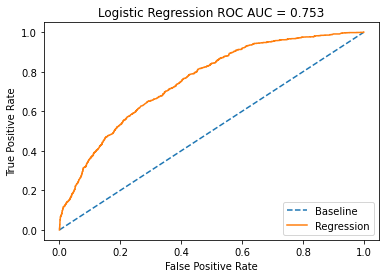

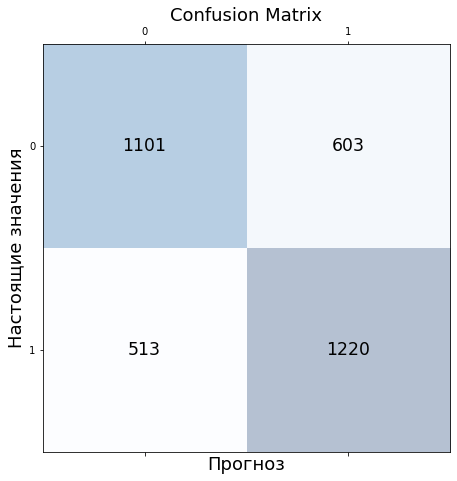

In [171]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(pd.get_dummies(cats_df), data['target'])

# cнова построим модель у обновлёнными данными
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=0)
model = LogisticRegression()
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:,1]

#рисуем ROC кривую
fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# рисуем confusion matrix
y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Прогноз', fontsize=18)
plt.ylabel('Настоящие значения', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

На тестовой выборке модель классифицировала:
 * 65% нулевого класса
 * 72% первого класса

Использую эту модель, с вероятностью 65% мы выдадим кредит ответственному заёмщику, в 35% откажем ему. И в 72% откажем заёмщику, который не вернёт его и в оставшихся 28% - согласуем его.

In [172]:
# итоговые значения information value:
ivtable

,variable,IV
0,price,0.019904
1,duration,0.023537
2,revenue_post,0.517321
3,days_from_first_sign_post_history,0.198034
4,contracts_all_post_history,0.128696
5,contracts_terminated_post_history,0.253934
6,distance,0.154403


In [173]:
# итоговые значения iv в разрегах групп признаков
iv_groups

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,gp_price,price <= 150000,122466,121647,819,0.134271,0.006688,0.134641,0.095332,0.345244,0.013571
1,gp_price,150000 < price <= 500000,147071,145504,1567,0.161248,0.010655,0.161046,0.182400,-0.124510,0.002659
2,gp_price,500000 < price <= 1000000,109252,108122,1130,0.119783,0.010343,0.119671,0.131533,-0.094508,0.001121
3,gp_price,1000000 < price <=1500000,136129,134811,1318,0.149251,0.009682,0.149211,0.153416,-0.027793,0.000117
4,gp_price,1500000 < price <=2500000,143683,142384,1299,0.157533,0.009041,0.157593,0.151205,0.041382,0.000264
5,gp_price,2500000 < price <=5000000,132138,130955,1183,0.144875,0.008953,0.144943,0.137702,0.051249,0.000371
6,gp_price,5000000 < price <= 10000000,67346,66654,692,0.073838,0.010275,0.073774,0.080549,-0.087867,0.000595
7,gp_price,price > 10000000,53997,53414,583,0.059202,0.010797,0.059120,0.067862,-0.137910,0.001206
8,gp_duration,<= 2 месяца,159329,157930,1399,0.174687,0.008781,0.174800,0.162845,0.070843,0.000847
9,gp_duration,2 месяца < <= 4 месяца,167524,165835,1689,0.183672,0.010082,0.183549,0.196601,-0.068694,0.000897


In [174]:
# обучим данные для модели, указав в предсказании нулевой класс
model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
probs = model.predict_proba(X_test)[:, 0]
preds = model.predict(X_test)

In [175]:
R = 40 / np.log(2)
A = 600 - (R*np.log(72))

In [176]:
# определим итоговый скор балл
score = A + R * -np.sum(X_test*model.coef_, axis=1)

In [177]:
# итоговая таблица сравнения
total_table = pd.DataFrame({'probability':probs, 'prediction': preds, 
                            'true': y_test, 'score': score})

In [178]:
total_table.sample(15)

,probability,prediction,true,score
6533,0.454350,1,0,372.719186
8175,0.552748,0,0,395.507396
13437,0.317031,1,1,338.998025
8064,0.453745,1,0,372.578288
13410,0.107257,1,1,260.999184
723,0.744539,0,0,445.015768
10178,0.685742,0,1,428.314691
1647,0.867061,0,0,491.500659
4683,0.846537,0,0,481.833076
10829,0.192677,1,1,300.607378
